# esBERTus: evaluation of the models results
In this notebook, an evaluation of the results obtained by the two models will be performed. The idea here is not as much to measure a benchmarking metric on the models but to understand the qualitative difference of the models.

In order to do so

## Keyword extraction
In order to understand what are the "hot topics" of the corpuses that are being used to train the models, a keyword extraction is performed.

Although the possibility to extract keywords based in a word embeddings approach has been considered, TF-IDF has been chosen over any other approach to model the discussion topic over the different corpuses due to it's interpretability

### Cleaning the texts
For this, a Spacy pipeline is used to speed up the cleaning process

In [80]:
from spacy.language import Language
import re
@Language.component("clean_lemmatize")
def clean_lemmatize(doc):
    text = doc.text
    text = re.sub(r'\w*\d\w*', r'', text) # remove words containing digits    
    text = re.sub(r'[^a-z\s]', '', text) # remove anything that is not a letter or a space
    return nlp.make_doc(text)

print('Done!')

Done!


In [2]:
import spacy
# Instantiate the pipeline, disable ner component for perfomance reasons
nlp = spacy.load("en_core_web_sm", disable=['ner'])

# Add custom text cleaning function
nlp.add_pipe('clean_lemmatize', before="tok2vec")

# Apply to EU data
with open('../data/02_preprocessed/full_eu_text.txt') as f:
    eu_texts = f.readlines()
    
nlp.max_length = max([len(text)+1 for text in eu_texts])
eu_texts = [' '.join([token.lemma_ for token in doc]) for doc in nlp.pipe(eu_texts, n_process=10)] # Get lemmas
with open('../data/04_evaluation/full_eu_text_for_tfidf.txt', 'w+') as f:
    for text in eu_texts:
        f.write(text)
        f.write('\n')

print('Done EU!')

# Apply to US data
with open('../data/02_preprocessed/full_us_text.txt') as f:
    us_texts = f.readlines()
    
nlp.max_length = max([len(text)+1 for text in us_texts])
us_texts = [' '.join([token.lemma_ for token in doc]) for doc in nlp.pipe(us_texts, n_process=10)] # Get lemmas
with open('../data/04_evaluation/full_us_text_for_tfidf.txt', 'w+') as f:
    for text in us_texts:
        f.write(text)
        f.write('\n')

print('Done US!')

print('Done!')

Done EU!
Done US!
Done!


### Keyword extraction
Due to the differences in legths and number of texts, it's not possible to use a standard approach to keywords extraction. TF-IDF has been considered, but it takes away most of the very interesting keywords such as "pandemic" or "covid". This is the reason why a hybrid approach between both of the European and US corpuses has been chosen.

The approach takes the top n words from one of the corpus that intersects with the top n words from the other corpus. In order to find the most relevant words, a simple count vector is used, that counts the frequency of the words. This takes only the words that are really relevant in both cases, even if you using a relatively naive approach.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Read the processed data
with open('../data/04_evaluation/full_eu_text_for_tfidf.txt') as f:
    eu_texts = f.readlines()
with open('../data/04_evaluation/full_us_text_for_tfidf.txt') as f:
    us_texts = f.readlines()
    
# Join the texts together
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
max_df = 0.9
max_features = 1000
cv_eu=CountVectorizer(max_df=max_df, stop_words=stopwords , max_features=max_features)
word_count_vector=cv_eu.fit_transform(eu_texts)
cv_us=CountVectorizer(max_df=max_df, stop_words=stopwords , max_features=max_features)
word_count_vector=cv_us.fit_transform(us_texts)
n_words = 200

keywords = [word for word in list(cv_eu.vocabulary_.keys())[:n_words] if word in list(cv_us.vocabulary_.keys())[:n_words]]
keywords

['response',
 'act',
 'national',
 'economic',
 'committee',
 'cause',
 'application',
 'january',
 'make',
 'service',
 'technical',
 'requirement',
 'approve',
 'consider',
 'appropriate',
 'year',
 'state',
 'effect',
 'may',
 'provide',
 'energy',
 'matter',
 'day',
 'december',
 'shall',
 'submit',
 'request',
 'authority',
 'receive',
 'status',
 'president',
 'third',
 'agency']

## Measure the models performance on masked tokens

### Extract sentences where the keywords appear

In [1]:
import spacy
from spacy.matcher import PhraseMatcher

keywords = ['coronavirus', 'covid', 'pandemic', 'epidemic', 'virus', 'emergency']

with open('../data/02_preprocessed/full_eu_text.txt') as f:
    eu_texts = f.readlines()

with open('../data/02_preprocessed/full_us_text.txt') as f:
    us_texts = f.readlines()
    
nlp = spacy.load("en_core_web_sm", disable=['ner'])
texts = [item for sublist in [eu_texts, us_texts] for item in sublist]

nlp.max_length = max([len(text) for text in texts])
phrase_matcher = PhraseMatcher(nlp.vocab)
patterns = [nlp(text) for text in keywords]
phrase_matcher.add('KEYWORDS', None, *patterns)

docs = nlp.pipe(texts, n_process=12)

sentences = []
block_size = 350
# Parse the docs for sentences
open('../data/04_evaluation/sentences.txt', 'wb').close()

print('Starting keyword extraction')
for doc in docs:
    for sent in doc.sents:
        # Check if the token is in the big sentence
        for match_id, start, end in phrase_matcher(nlp(sent.text)):
            if nlp.vocab.strings[match_id] in ["KEYWORDS"]:    
                # Create sentences of length of no more than block size
                tokens = sent.text.split(' ')
                if len(tokens) <= block_size:
                    sentence = sent.text
                else:
                    sentence = " ".join(tokens[:block_size])
                with open('../data/04_evaluation/sentences.txt', 'ab') as f:
                        f.write(f'{sentence}\n'.encode('UTF-8'))
                
print(f"There are {len(open('../data/04_evaluation/sentences.txt', 'rb').readlines())} sentences containing keywords")

Starting keyword extraction
There are 15868 sentences containing keywords


### Measure the probability of outputing the real token in the sentence

In [2]:
# Define a custom function that feeds the three models an example and returns the perplexity
def get_masked_token_probaility(sentence:str, keywords:list, models_pipelines:list):
    # Find the word in the sentence to mask
    sentence = sentence.lower()
    keywords = [keyword.lower() for keyword in keywords]
    target = None
    for keyword in keywords:
        # Substitute only the first matched keyword
        if keyword in sentence:
            target = keyword
            masked_sentence = sentence.replace(keyword, '{}', 1)
            break
    
    if target:
        model_pipeline_results = []
        for model_pipeline in models_pipelines:
            masked_sentence = masked_sentence.format(model_pipeline.tokenizer.mask_token)
            try:
                result = model_pipeline(masked_sentence, targets=target)
                model_pipeline_results.append(result[0]['score'])
            except Exception as e:
                model_pipeline_results.append(0)
        
        return keyword, model_pipeline_results

In [3]:
from transformers import pipeline, AutoModelForMaskedLM, DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('../data/03_models/tokenizer/')

# The best found European model
model=AutoModelForMaskedLM.from_pretrained("../data/03_models/eu_bert_model")
eu_model_pipeline = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

# The best found US model
model=AutoModelForMaskedLM.from_pretrained("../data/03_models/us_bert_model")
us_model_pipeline = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

model_checkpoint = 'distilbert-base-uncased'
# The baseline model from which the trainin
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
base_model_pipeline = pipeline(
    "fill-mask",
    model=model,
    tokenizer=model_checkpoint
)

In [1]:
keywords = ['coronavirus', 'covid', 'pandemic', 'epidemic', 'virus', 'emergency']
results = []

print(f"There are {len(open('../data/04_evaluation/sentences.txt').readlines())} sentences to be evaluated")

for sequence in open('../data/04_evaluation/sentences.txt').readlines():
    results.append(get_masked_token_probaility(sequence, keywords, [eu_model_pipeline, us_model_pipeline, base_model_pipeline]))
    
import pickle
pickle.dump(results, open('../data/04_evaluation/sentence_token_prediction.pickle', 'wb'))

There are 15868 sentences to be evaluated


#### Evaluate the results

In [5]:
import pickle
results = pickle.load(open('../data/04_evaluation/sentence_token_prediction.pickle', 'rb'))
results[0:5]

[('covid', [0.9999561309814453, 0.9862261414527893, 9.282930477638729e-06]),
 ('covid', [0.9999682903289795, 0.9958993792533875, 0.012131353840231895]),
 None,
 ('covid', [0.9998469352722168, 0.8159339427947998, 1.5820044154679636e-06]),
 None]

##### Frequences of masked words in the pipeline

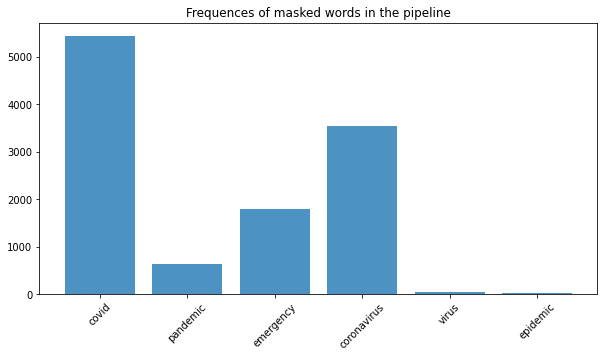

In [6]:
import collections
import numpy as np
import matplotlib.pyplot as plt
words = collections.Counter([result[0] for result in results if result!=None])
labels, values = zip(*words.items())

indexes = np.arange(len(labels))
fix, ax = plt.subplots(figsize=(10,5))
ax.set_xticks(range(len(words)))
plt.bar(indexes, values, width=.8, align="center",alpha=.8)
plt.xticks(indexes, labels, rotation=45)

plt.title('Frequences of masked words in the pipeline')
plt.show()

##### Average probability of all the masked keywords by model

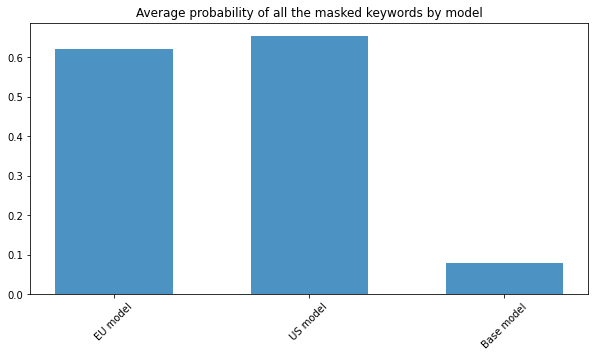

In [7]:
n_results = len([result for result in results if result!=None])
eu_results = sum([(result[1][0]) for result in results if result!=None]) / n_results
us_results = sum([(result[1][1]) for result in results if result!=None]) / n_results
base_results = sum([(result[1][2]) for result in results if result!=None]) / n_results

labels = ['EU model', 'US model', 'Base model']
values = [eu_results, us_results, base_results]

indexes = np.arange(len(labels))
fix, ax = plt.subplots(figsize=(10,5))
ax.set_xticks(range(len(words)))
plt.bar(indexes, values, width=.6, align="center",alpha=.8)
plt.xticks(indexes, labels, rotation=45)

plt.title('Average probability of all the masked keywords by model')
plt.show()

### Get the first predicted token in each sentence, masking

In [28]:
def get_first_predicted_masked_token(sentence:str, eu_pipeline, us_pipeline, base_pipeline):
    sentence = sentence.lower()
    model_pipeline_results = []
    eu_model_pipeline_results = eu_pipeline(sentence.format(eu_pipeline.tokenizer.mask_token), top_k=1)
    us_model_pipeline_results = us_pipeline(sentence.format(us_pipeline.tokenizer.mask_token), top_k=1)
    base_model_pipeline_results = base_pipeline(sentence.format(base_pipeline.tokenizer.mask_token), top_k=1)
    
    return (eu_model_pipeline_results[0]['token_str'].replace(' ', ''), 
            us_model_pipeline_results[0]['token_str'].replace(' ', ''), 
            base_model_pipeline_results[0]['token_str'].replace(' ', '')
           )

get_first_predicted_masked_token(sentence, eu_model_pipeline, us_model_pipeline, base_model_pipeline)

('coronavirus', 'virus', 'influenza')

In [42]:
# Create a function that identifies the first keyword in the sentences, masks it and feeds the it to the prediction function
keywords = ['coronavirus', 'covid', 'covid-19', 'pandemic', 'epidemic', 'virus', 'emergency']
results = []
for sequence in open('../data/04_evaluation/sentences.txt').readlines():
    target = None
    for keyword in keywords:
        if keyword in sequence:
            target = keyword
            break
    if target:
        masked_sentence = sequence.replace(target, '{}', 1)
        try:
            predictions = get_first_predicted_masked_token(masked_sentence, eu_model_pipeline, us_model_pipeline, base_model_pipeline)
            results.append({'masked_token': target, 
                           'eu_prediction': predictions[0],
                           'us_prediction': predictions[1],
                           'base_prediction': predictions[2]})
        except:
            pass

import pickle
pickle.dump(results, open('../data/04_evaluation/sentence_first_predicted_tokens.pickle', 'wb'))

#### Evaluate the results

In [63]:
import pickle
results = pickle.load(open('../data/04_evaluation/sentence_first_predicted_tokens.pickle', 'rb'))
print(len(results))

11472


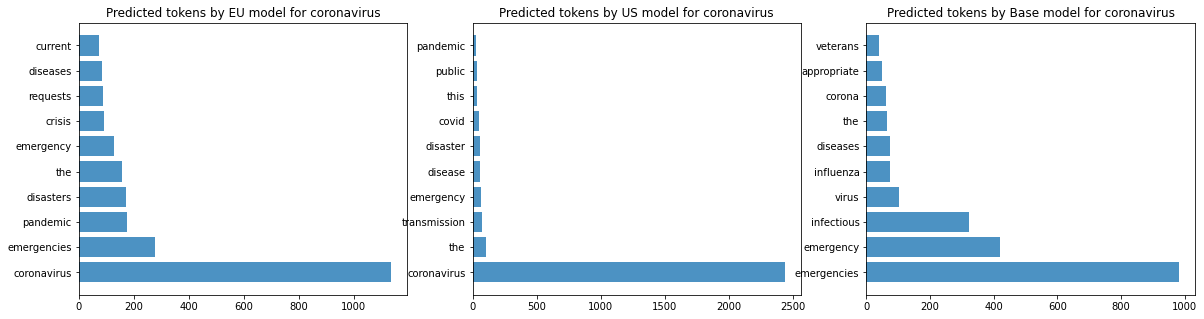

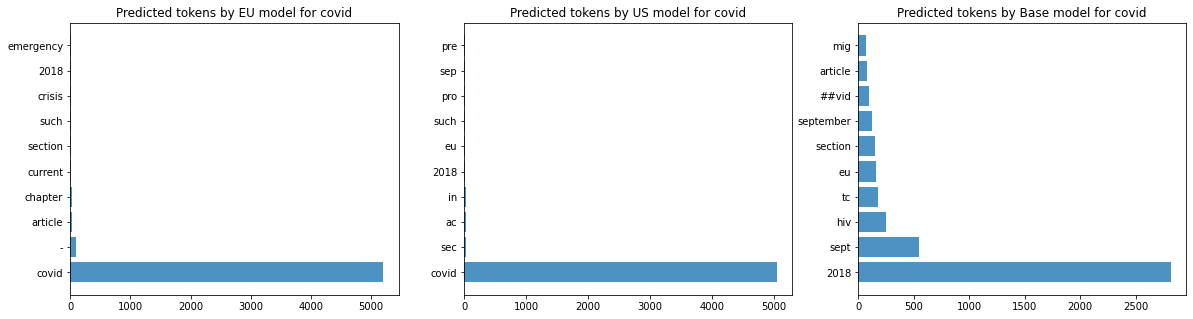

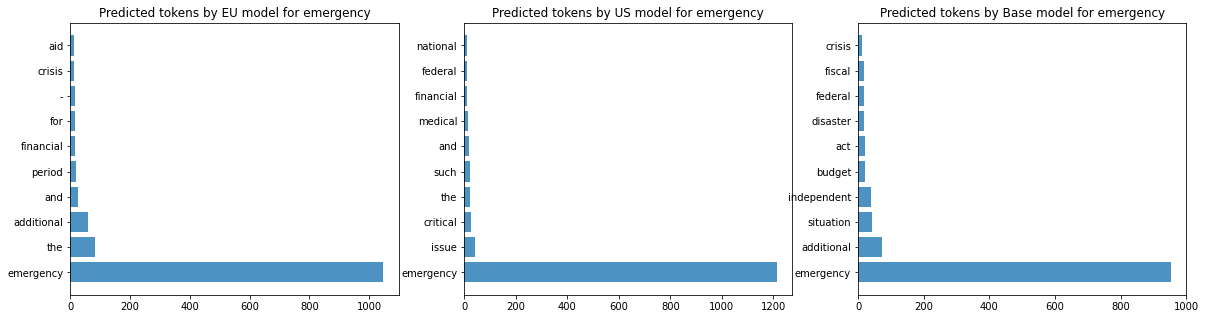

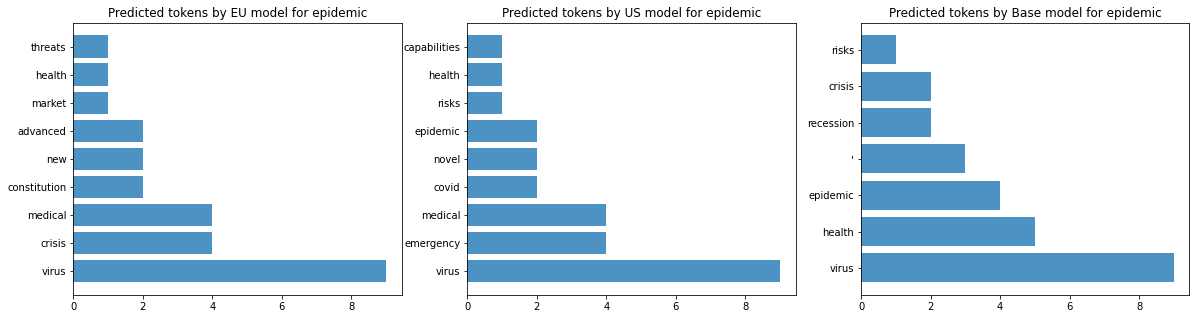

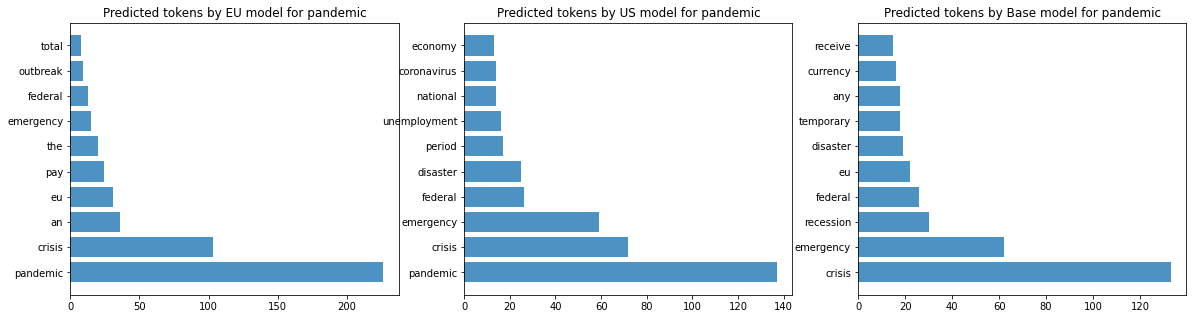

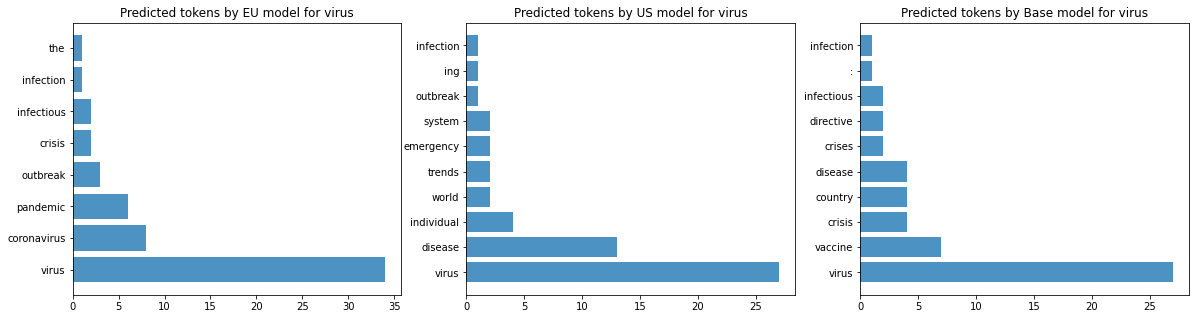

In [113]:
# Group the results by masked token
from itertools import groupby
from operator import itemgetter
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
n_words = 10
results = sorted(results, key=itemgetter('masked_token'))

for keyword, v in groupby(results, key=lambda x: x['masked_token']):
    token_results = list(v)
    
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    for idx, (key, name) in enumerate(zip(['eu_prediction', 'us_prediction', 'base_prediction'], ['EU', 'US', 'Base'])):
        words = Counter([item[key] for item in token_results]).most_common(n_words)
        labels, values = zip(*words)

        ax[idx].barh(labels, values, align="center",alpha=.8)
        ax[idx].set_title(f'Predicted tokens by {name} model for {keyword}')

    plt.show()

## Qualitative evaluation of masked token prediction
The objective of this section is not to compare the score obtained by all the models that are being used, but to compare what are the qualitative outputs of these models. This means that the comparison is going to be done manually, by inputing phrases that contain words related to the COVID-19 pandemic, and comparing the outputs of the models among them, enabling the possibility of discussion of these results.

### Feeding selected phrases belonging to the European and United States institutions websites

In [20]:
def get_masked_token(sentence:str, eu_pipeline, us_pipeline, base_pipeline, n_results=1):
    sentence = sentence.lower()
    model_pipeline_results = []
    eu_model_pipeline_results = eu_pipeline(sentence.format(eu_pipeline.tokenizer.mask_token), top_k =n_results)
    us_model_pipeline_results = us_pipeline(sentence.format(us_pipeline.tokenizer.mask_token), top_k =n_results)
    base_model_pipeline_results = base_pipeline(sentence.format(base_pipeline.tokenizer.mask_token), top_k =n_results)
     
    for idx,(eu_prediction, us_prediction, base_prediction) in enumerate(zip(eu_model_pipeline_results, us_model_pipeline_results, base_model_pipeline_results)):
        print(f"EUROPEAN MODEL {idx+1} token is       {eu_prediction['token_str'].replace(' ', '')} | {eu_prediction['sequence']}")
        print(f"UNITED STATES MODEL {idx+1} token is  {us_prediction['token_str'].replace(' ', '')} | {us_prediction['sequence']}")
        print(f"BASE MODEL {idx+1} token is            {base_prediction['token_str'].replace(' ', '')} | {base_prediction['sequence']}")
        print('--------------------------------')

In [3]:
from transformers import pipeline, AutoModelForMaskedLM, DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('../data/03_models/tokenizer/')

# The best found European model
model=AutoModelForMaskedLM.from_pretrained("../data/03_models/eu_bert_model")
eu_model_pipeline = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

# The best found US model
model=AutoModelForMaskedLM.from_pretrained("../data/03_models/us_bert_model")
us_model_pipeline = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

model_checkpoint = 'distilbert-base-uncased'
# The baseline model from which the trainin
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
base_model_pipeline = pipeline(
    "fill-mask",
    model=model,
    tokenizer=model_checkpoint
)

In [ ]:
# Source https://ec.europa.eu/info/live-work-travel-eu/coronavirus-response_en
# Masked token: coronavirus
sentence = 'The European Commission is coordinating a common European response  to the {} outbreak. We are taking resolute action to reinforce our public health sectors and mitigate the socio-economic impact in the European Union. We are mobilising all means at our disposal to help our Member States coordinate their national responses and are providing objective information about the spread of the virus and effective efforts to contain it.'
get_masked_token(sentence, eu_model_pipeline, us_model_pipeline, base_model_pipeline)

In [9]:
# Source https://ec.europa.eu/info/live-work-travel-eu/coronavirus-response_en
# Masked token: vaccine
sentence = 'A safe and effective {} is our best chance to beat coronavirus and return to our normal lives'
get_masked_token(sentence, eu_model_pipeline, us_model_pipeline, base_model_pipeline)

EUROPEAN MODEL 0 token is       {'sequence': 'a safe and effective solution is our best chance to beat coronavirus and return to our normal lives', 'score': 0.3421868085861206, 'token': 5576, 'token_str': 's o l u t i o n'}
UNITED STATES MODEL 0 token is  {'sequence': 'a safe and effective strategy is our best chance to beat coronavirus and return to our normal lives', 'score': 0.2966555655002594, 'token': 5656, 'token_str': 's t r a t e g y'}
OLD MODEL 0 token is            {'sequence': 'a safe and effective vaccine is our best chance to beat coronavirus and return to our normal lives', 'score': 0.6729866862297058, 'token': 17404, 'token_str': 'vaccine'}
--------------------------------
EUROPEAN MODEL 1 token is       {'sequence': 'a safe and effective response is our best chance to beat coronavirus and return to our normal lives', 'score': 0.14953412115573883, 'token': 3433, 'token_str': 'r e s p o n s e'}
UNITED STATES MODEL 1 token is  {'sequence': 'a safe and effective vaccine is 